# Vectorization Notebook

This notebook is dedicated to make my gradient evaluation code fast by using the XLA (Accelerated Linear Algebra) vector operations from jax to compute them (instead of the insanely slow python iterators I've previously been using). This is a bit of a pain to write though, hence the dedicated notebook.

In [338]:
""" Includes """
import jax
from jax import numpy as jnp
import jax.nn as nn
import matplotlib.pyplot as plt
from env.mdp import Sampler, MarkovDecisionProcess
from env.gridworld import Gridworld, gridplot
from algs.policy_gradients import Sampler
from itertools import accumulate

def flatten(v):
    return jnp.reshape(v,(list(accumulate(v.shape,lambda x,y:x*y))[-1],))

""" Initialize the Jax RNG """
key = jax.random.PRNGKey(0) 
from jax.config import config; config.update("jax_enable_x64", True)

### Instantiating some example MDP
We instantiate a $2 \times 1$ `gridworld`, to have the simplest possible example for debugging.

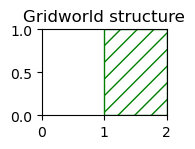

In [339]:
R = 100
goals = [((1,0),R)]
gridMDP = Gridworld(2,1,0.1,0.9,goals=goals,obstacles=[]) 
gridMDP.init_distrib =  jnp.exp(jax.random.uniform(key,(gridMDP.n,))) / \
    jnp.sum(jnp.exp(jax.random.uniform(key,(gridMDP.n,))))
    
fig, ax = plt.subplots(1,figsize=(2,1.6))
gridplot(gridMDP,ax,goals=goals)
ax.set_title('Gridworld structure')
fig.tight_layout()
plt.show()

We also choose to use a direct `softmax` policy parametrization, which we define here:

In [340]:
"""We define our policy parametrization"""
parametrization = lambda p : nn.softmax(p,axis=1)
"""As well as some random policy parameter vector"""
theta = jax.random.uniform(key,(gridMDP.n,gridMDP.m)) # where the dimensionality matches the MDP

### Sampling an MDP

A quick profiling of the naive (very very slow) implementation of GPOMDP tells us that about $\approx 90\%$ of the performance is lost in the GPOMDP gradient computation (and not in the batch sampling), so although on paper it should be possible to paralellize pretty well for discrete MDPs - when sampling batches - we decide not to consider vectorization of the sampling routine.

In [341]:
""" We must define an horizon and a batch size """
HORIZON = 3
BATCH = 5

""" Generic trajectory sampling routine for MDPs """
def sample_trajectory(pi : jnp.ndarray ,mdp: MarkovDecisionProcess,smp : Sampler,H : int,key : jax.random.PRNGKeyArray):
    """ Samples a single trajectory
    """
    def pick_action(pi : jnp.ndarray,s:int,mdp:MarkovDecisionProcess):
        p = pi[s]; p /= jnp.sum(p)
        return jax.random.choice(key,jnp.arange(mdp.m), p = p)
        
    traj = []
    r_t = 0
    s_t = smp.reset()
    for _ in range(H):
        a_t = pick_action(pi,s_t,mdp)
        traj += [(s_t,a_t,r_t)]
        s_t, r_t = smp.step(a_t)
    return traj

""" Samples a batch of trajectories """
def sample_batch(pi:jnp.ndarray,mdp:MarkovDecisionProcess,smp:Sampler,H:int,B:int,key:jax.random.PRNGKeyArray):
    """ Samples a batch of trajectories
    """
    subkeys = jax.random.split(key,B)
    return [sample_trajectory(pi,mdp,smp,H,k) for k in subkeys]

""" The sampler object handlers random sampling of MDP steps """
sampler = Sampler(gridMDP,key)

batch = sample_batch(parametrization(theta),gridMDP,sampler,HORIZON,BATCH,key)

print(f'The batch object is an object of class {type(batch)} (of length {len(batch)}, which is the batch size), \n which contains trajectories (which are of {type(batch[0])} and of lenght {len(batch[0])}, which is the horizon). \n Each trajectory element is a {type(batch[0][0])} which contains 3 elements: the state, the action and the reward.')
print('\nThe batch that we just sampled prints as: \n')
print(batch)

The batch object is an object of class <class 'list'> (of length 5, which is the batch size), 
 which contains trajectories (which are of <class 'list'> and of lenght 3, which is the horizon). 
 Each trajectory element is a <class 'tuple'> which contains 3 elements: the state, the action and the reward.

The batch that we just sampled prints as: 

[[(DeviceArray(1, dtype=int64), DeviceArray(1, dtype=int64), 0), (DeviceArray(0, dtype=int64), DeviceArray(1, dtype=int64), 100.0), (DeviceArray(0, dtype=int64), DeviceArray(1, dtype=int64), -1.0)], [(DeviceArray(1, dtype=int64), DeviceArray(3, dtype=int64), 0), (DeviceArray(1, dtype=int64), DeviceArray(3, dtype=int64), -1.0), (DeviceArray(1, dtype=int64), DeviceArray(3, dtype=int64), -1.0)], [(DeviceArray(1, dtype=int64), DeviceArray(1, dtype=int64), 0), (DeviceArray(0, dtype=int64), DeviceArray(1, dtype=int64), 100.0), (DeviceArray(0, dtype=int64), DeviceArray(1, dtype=int64), -1.0)], [(DeviceArray(1, dtype=int64), DeviceArray(1, dtype=int6

### Computing GPOMDP gradients the ugly (and really slow) way

The `GPOMDP` estimator which has the following form:
$$
g_\theta = 
\frac{1}{B} \sum^B_{i=1} \sum^{H-1}_{h=0} r_h^i \gamma^h
\Big( \sum^{h}_{j=0} \nabla_\theta \log \pi_\theta(a_j^i|s_j^i)  \Big)
\approx \nabla_\theta J(\theta)
$$

Which lends itself very easily to an incredibly slow python iterator implementation. Which we give below. This implementation is tested and we know that it gives correct gradients, so we will use it as a way of checking the validity of our vectorized `jax` implementation.

In [284]:
def gpomdp(batch,theta,B,H,gamma,parametrization):
    def g_log(theta,s,a):
        return jax.grad(lambda p : jnp.log(parametrization(p))[s,a])(theta)
    def trace_grad(batch,theta,b,h):
        return jnp.sum(jnp.array([g_log(theta,e[0],e[1]) for e in batch[b][:h]]),axis=0)
    def single_sample_gpomdp(batch,theta,b,H):
        return jnp.sum(jnp.array([(gamma**h)*batch[b][h][2] \
                    *trace_grad(batch,theta,b,h) for h in range(1,H)]),axis=0) #something is fucked here actually
    return (1/B)*jnp.sum(jnp.array([single_sample_gpomdp(batch,theta,b,H) for b in range(B)]),axis=0)

This gives a gradient of shape $S \times A$, which here is $2 \times 4$.

In [285]:
reference_gradient = gpomdp(batch,theta,BATCH,HORIZON,gridMDP.gamma,parametrization)
print(reference_gradient, reference_gradient.shape)

[[ 0.30037406 -1.04648386  0.32618588  0.41992391]
 [ 0.25095342  0.16381175  0.2803066  -0.69507177]] (2, 4)


### Vectorized implementation of the gradient estimator
The general idea behind the vectorized implementation is to 

0) properly batch the data
1) compute all the gradients $\nabla_\theta \log \pi_\theta(a_j^i|s_j^i)$ in parallel (using a `jax.vmap` operator)
2) compute the sums $\sum^{h}_{j=0} \nabla_\theta \log \pi_\theta(a_j^i|s_j^i)$ using a parallelized cumulative sum operator
3) compute the terms $r_h^i \gamma^h \Big( \sum^{h}_{j=0} \nabla_\theta \log \pi_\theta(a_j^i|s_j^i)  \Big)$ in parrallel using elementwise mutliplication
4) sum everything together along the batch and horizon axes to get the gradient estimation

In [286]:
""" First (0.) we batch the data together into three separate jax deviceArrays"""
s_batch = jnp.array([[e[0] for e in s] for s in batch])
a_batch = jnp.array([[e[1] for e in s] for s in batch])
r_batch = jnp.array([[e[2] for e in s] for s in batch])
print("We have two integer arrays (for state and actions) and a float array (for rewards)")
print("All arrays have the same shape:")
print(s_batch.shape,a_batch.shape, r_batch.shape)
print(",which is (BATCH, HORIZON).")

We have two integer arrays (for state and actions) and a float array (for rewards)
All arrays have the same shape:
(5, 3) (5, 3) (5, 3)
,which is (BATCH, HORIZON).


In [287]:
"""Next (1.) we compute the batched gradients"""

"""This operation has multiple steps, first we define a gradient of log function and use 
a lambda expression to get it to have a prototype which is easier to vmap over later"""
def g_log(s,a,theta,parametrization):
    return jax.grad(lambda p : jnp.log(parametrization(p))[s,a])(theta)
_f = lambda s,a : g_log(s,a,theta,parametrization)

"""The we generate ou gradient array by using a double jax.vmap operation (which is required because
    we are vmapping over two different axes)"""
batch_grads = jax.vmap(jax.vmap(_f))(s_batch, a_batch) ##vmap can only operate on a single axis 

print(f"This generates quite a complex shaped tensor, it has shape: {batch_grads.shape}, \nwhich is (BATCH,HORIZON,STATE,ACTION), if we slice the array \nand look at a single gradient in the gradient tensor what we have is something like that:")
print(batch_grads[0,0,:,:])
print(f"Which is the gradient of the log of the policy parametrization of whatever action was taken at \nsome state action pair (s,a) corresponding to some step of some trajectory in the batch.\nThis element is of shape {batch_grads[0,0,:,:].shape}, whcih stands for (STATE,ACTION).")

This generates quite a complex shaped tensor, it has shape: (5, 3, 2, 4), 
which is (BATCH,HORIZON,STATE,ACTION), if we slice the array 
and look at a single gradient in the gradient tensor what we have is something like that:
[[-0.1986601   0.69211895 -0.2157314  -0.27772746]
 [ 0.          0.          0.          0.        ]]
Which is the gradient of the log of the policy parametrization of whatever action was taken at 
some state action pair (s,a) corresponding to some step of some trajectory in the batch.
This element is of shape (2, 4), whcih stands for (STATE,ACTION).


In [288]:
"""What we do next (2.) is that we take a cumulative sum of the batched gradients along the horizon axis"""

# Recall the grad tensor is of shape (BATCH,HORIZON,STATE,ACTION), so axis 1 is the time axis
summed_grads = jnp.cumsum(batch_grads,axis=1) 

print(f"Gradients for (a0, s0) at all time steps in trajectory 0 of the batch:\
        \n{[(t,float(batch_grads[0,t,0,0])) for t in range(HORIZON)]}\
        \nAccumulated gradients for (a0, s0) at all time steps in trajectory 0 of the batch:\
        \n{[(t,float(summed_grads[0,t,0,0])) for t in range(HORIZON)]}") 

Gradients for (a0, s0) at all time steps in trajectory 0 of the batch:        
[(0, -0.1986600953106976), (1, -0.1986600953106976), (2, -0.1986600953106976)]        
Accumulated gradients for (a0, s0) at all time steps in trajectory 0 of the batch:        
[(0, -0.1986600953106976), (1, -0.3973201906213952), (2, -0.5959802859320927)]


In [289]:
"""Then (3.) we multiply our accumulated gradients with the discount factors and rewards"""

gamma_tensor = gridMDP.gamma**jnp.arange(HORIZON) #here we build a discount factor tensor of the right shape
gamma_tensor = jnp.repeat(jnp.repeat(jnp.repeat(
    gamma_tensor[jnp.newaxis, :, jnp.newaxis, jnp.newaxis], 
        BATCH, axis=0), summed_grads.shape[2],axis=2), summed_grads.shape[3],axis=3)
reward_tensor = jnp.repeat(jnp.repeat(
    r_batch[:, :, jnp.newaxis, jnp.newaxis], 
    summed_grads.shape[2], axis=2),
        summed_grads.shape[3],axis=3) #here we repeat the reward along the right axes so we can elementwise multiply with the gradients

gradient_tensor = summed_grads[:,:-1,:,:] * reward_tensor[:,1:,:,:] * gamma_tensor[:,1:,:,:] # finally we get our gradients
print(f'Which gives us a tensor of the same shape as the previous one: {gradient_tensor.shape}')

Which gives us a tensor of the same shape as the previous one: (5, 2, 2, 4)


In [290]:
"""Finally (4.) summing over the batch and horizon axes we get our gradient value"""
fast_gradient = (1/BATCH)*jnp.sum(gradient_tensor,axis=(0,1))
print(f"The final gradient is thus:\n{fast_gradient}")

The final gradient is thus:
[[ 0.30037406 -1.04648386  0.32618588  0.41992391]
 [ 0.25095342  0.16381175  0.2803066  -0.69507177]]


Bringing everything together into a function we get:

In [305]:
def fast_gpomdp(batch,theta,B,H,gamma,parametrization):
    def g_log(s,a,theta,parametrization):
        return jax.grad(lambda p : jnp.log(parametrization(p))[s,a])(theta)
    _f = lambda s,a : g_log(s,a,theta,parametrization)
    
    s_batch = jnp.array([[e[0] for e in s] for s in batch])
    a_batch = jnp.array([[e[1] for e in s] for s in batch])
    r_batch = jnp.array([[e[2] for e in s] for s in batch])

    batch_grads = jax.vmap(jax.vmap(_f))(s_batch, a_batch) ##vmap can only operate on a single axis 
    summed_grads = jnp.cumsum(batch_grads,axis=1) 

    gamma_tensor = gamma**jnp.arange(H) #here we build a discount factor tensor of the right shape
    gamma_tensor = jnp.repeat(jnp.repeat(jnp.repeat(
        gamma_tensor[jnp.newaxis, :, jnp.newaxis, jnp.newaxis], 
            B, axis=0), summed_grads.shape[2],axis=2), summed_grads.shape[3],axis=3)
    reward_tensor = jnp.repeat(jnp.repeat(
        r_batch[:, :, jnp.newaxis, jnp.newaxis], 
        summed_grads.shape[2], axis=2),
            summed_grads.shape[3],axis=3) #here we repeat the reward along the right axes so we can elementwise multiply with the gradients

    gradient_tensor = summed_grads[:,:-1,:,:] * reward_tensor[:,1:,:,:] * gamma_tensor[:,1:,:,:] # finally we get our gradients

    return (1/B)*jnp.sum(gradient_tensor,axis=(0,1))

### Quantifying the performance improvement
In order to get an idea of how much more performant the vectorized code is compared to the iterator implementation we generate a more complex MDP, and then time both functions.

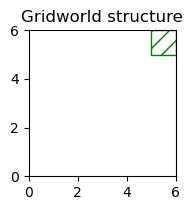

In [292]:
R = 100; goals = [((5,5),R)]
largeMDP = Gridworld(6,6,0.1,0.9,goals=goals,obstacles=[]) 
largeMDP.init_distrib =  jnp.exp(jax.random.uniform(key,(largeMDP.n,))) / \
    jnp.sum(jnp.exp(jax.random.uniform(key,(largeMDP.n,))))
    
    
fig, ax = plt.subplots(1,figsize=(2,2.2))
gridplot(largeMDP,ax,goals=goals)
ax.set_title('Gridworld structure'); fig.tight_layout(); plt.show()

We sample a batch

In [325]:
HORIZON = 10
BATCH = 20

"""As well as some random policy parameter vector"""
theta = jax.random.uniform(key,(largeMDP.n,largeMDP.m)) # where the dimensionality matches the MDP
largeMDPsampler = Sampler(largeMDP,key)
largeBatch = sample_batch(parametrization(theta),largeMDP,largeMDPsampler,HORIZON,BATCH,key)

We now compare the gradient computation times

In [326]:
%timeit gpomdp(batch,theta,BATCH,HORIZON,gridMDP.gamma,parametrization)
reference_gradient = gpomdp(batch,theta,BATCH,HORIZON,gridMDP.gamma,parametrization)

13.7 s ± 545 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [327]:
%timeit fast_gpomdp(batch,theta,BATCH,HORIZON,gridMDP.gamma,parametrization)
fast_gradient = fast_gpomdp(batch,theta,BATCH,HORIZON,gridMDP.gamma,parametrization)

215 ms ± 6.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


So the vectorized implementation is about 63x times faster that its iterator counterpart. Let's visualize the gradients to confirm they are indeed the same.

Text(0.5, 1.0, 'Log of vector computed gradients')

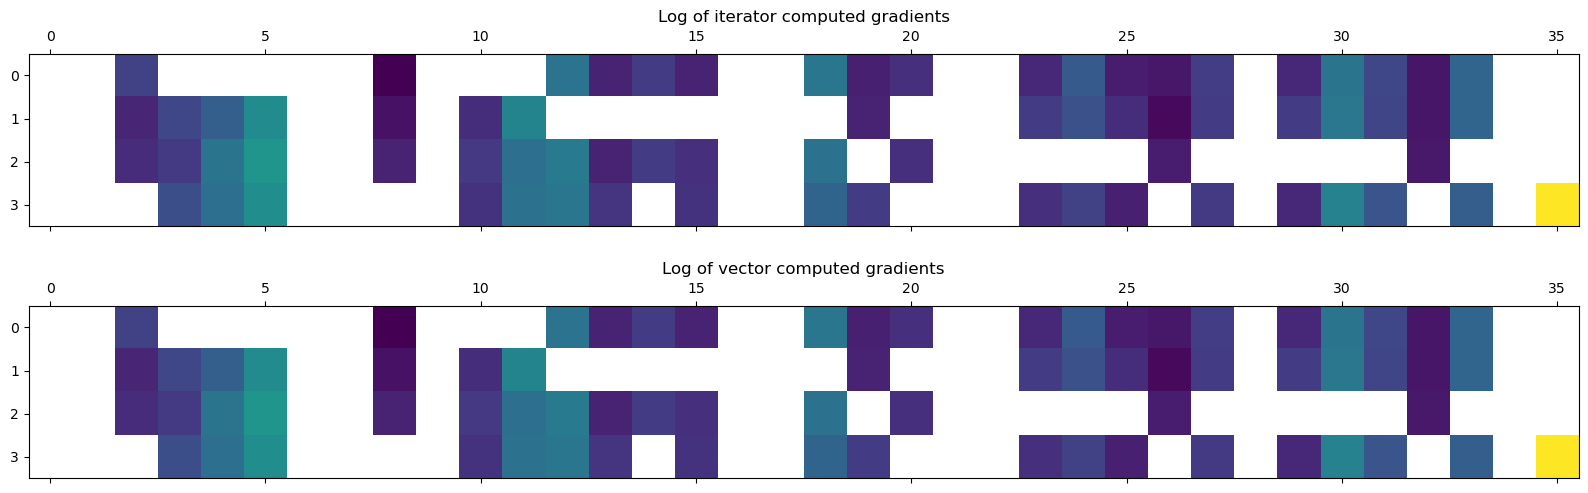

In [337]:
fig, ax = plt.subplots(2,1,figsize=(20,6))
ax[0].matshow(jnp.log(reference_gradient.transpose()))
ax[0].set_title('Log of iterator computed gradients')
ax[1].matshow(jnp.log(fast_gradient.transpose()))
ax[1].set_title('Log of vector computed gradients')